In [2]:
from google.colab import drive # remove the cell if not using colab
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
base_path = Path('/content/drive/MyDrive/Colab Notebooks/zadanie 1/') # change path here!

# Klasyfikacja pasażerów Titanica
Po wysłaniu raportu pozostało już tylko czekać. Dni mijały, ale w końcu telefon zadzwonił. Okazało się, że po konsultacji Twojego raportu z najbardziej doświadczonymi specjalistami w dziedzinie, zleceniodawca zdecydował się powierzyć Ci dalszą część tajemniczego zadania. Chodzi oczywiście o... **stworzenie modelu przewidującego szanse przeżycia katastrofy Titanica**.


#### Twoim celem będzie jest wytrenowanie modeli do klasyfikacji każdego pasażera Titanica jako ofiary (0) lub osoby, która przeżyła (1).

Poniżej znajdziesz pytania, które mogą być pomocne w zadaniu:

- Czego nauczyło Cię o badanym zbiorze danych poprzednie zadanie? Jak możesz wykorzystać wyciągnięte z niego wnioski w procesie tworzenia modelu?
- Jak przeprowadzenie standaryzacji danych może wpływać na zachowanie modelu?
- Co mój model robi i w jaki sposób?
- Jak nie przetrenować wybranego modelu?
- Jaki wynik klasyfikacji możemy uznać za *dobry*?


Wymagania:
- Wypisz obserwacje z pierwszego zadania, które pomogą Ci w tym. Co było przydatne, a co okazało się bezużyteczne?
- [Nie doprowadź](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) do ~~przecieku statku~~ wycieku danych (np. nie ucz modelu na danych testowych). Nauczone modele odpal na danych treningowych i testowych - opisz uzyskane wyniki.
- Stwórz baseline, czyli dla porównania sprawdź jak z zadaniem radzi sobie [Dummy Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html) (jeśli Twój docelowy model radzi sobie gorzej - uciekaj)
- Przeprowadź badania na dwóch wybranych modelach uczenia maszynowego (np. spośród: drzew decyzyjnych, SVM, MLP, KNN, z gwiazdką [XGBoost](https://xgboost.readthedocs.io/en/stable))
- W badaniach użyj wybranych metryk. Wybór uzasadnij.
- Dla każdego modelu wybierz co najmniej dwa hiperparametry i przeprowadź badania zależności wyników metryk od wartości hiperparametrów. Zwizualizuj wszystko ładnie, zastanów się dlaczego tak mogło być i wyciągnij i wypisz wnioski.
- Podsumuj przeprowadzone badania, wypisz wnioski.

Niezmiennie, zadbaj o czytelność kodu i nazewnictwo zmiennych. Jeśli jakiś wycinek kodu się powtarza, to wyodrębnij go do funkcji. Postaraj się zamieszczać swoje wnioski w postaci komentarza `Markdown`.

Jeśli chcesz, możesz sprawdzić (przyjmując pewne założenia), jakie byłyby Twoje szanse na Titanicu.

Uwaga! Jeśli Titanic to dla Ciebie nic i baaaaardzo chcesz to możesz w ramach tego zadania zająć się [bardziej wymagającym](https://archive.ics.uci.edu/dataset/365/polish+companies+bankruptcy+data) zbiorem.

In [4]:
titanic_df = pd.read_csv(base_path / 'titanic.csv', index_col='PassengerId')

In [5]:
titanic_df['Cabin'].str[0].unique()

array([nan, 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

W poprzednim zadaniu jakoś mi umknęło przystowanie danych do modelu i zająłem się jedynie badaniem przeżycia pasażerów(nie wiem jak) więc zaczne od tego.

In [6]:
print("Liczba braków danych w każdej kolumnie:")
print(titanic_df.isna().sum())

Liczba braków danych w każdej kolumnie:
Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare         98
Cabin       687
Embarked      2
dtype: int64


 Z poprzedniego zadania wiem że wypełnienie kolumny Age za pomocą mediany było błędnym podejściem więc zastosuje inną metodę. Wyodrębnie tytuły poszczególnych osób i zastosuję mediane wieku dla osób z nieznanym wiekiam na podstawie ich tytułu (mam nadzieje że to co napisałem ma sens).

In [7]:
titanic_df['Title'] = titanic_df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
print(titanic_df['Title'].value_counts())

Title
Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Mlle          2
Major         2
Ms            1
Mme           1
Don           1
Lady          1
Sir           1
Capt          1
Countess      1
Jonkheer      1
Name: count, dtype: int64


Mamy parę "dziwnych" tytułów więc je uogólnie.


In [8]:
titanic_df['Title'] = titanic_df['Title'].replace(['Lady', 'Countess', 'Sir', 'Jonkheer', 'Dona', 'Don'], 'Royal')
titanic_df['Title'] = titanic_df['Title'].replace(['Capt', 'Col', 'Dr', 'Major', 'Rev'], 'Officer')
titanic_df['Title'] = titanic_df['Title'].replace('Mlle', 'Miss')
titanic_df['Title'] = titanic_df['Title'].replace('Ms', 'Miss')
titanic_df['Title'] = titanic_df['Title'].replace('Mme', 'Mrs')
print(titanic_df['Title'].value_counts())

Title
Mr         517
Miss       185
Mrs        126
Master      40
Officer     18
Royal        5
Name: count, dtype: int64


In [9]:
missing_age_by_title = titanic_df.groupby('Title')['Age'].apply(lambda x: x.isna().sum())

print("Liczba braków danych w kolumnie 'Age' dla każdego tytułu (przed uzupełnieniem):")
print(missing_age_by_title)

Liczba braków danych w kolumnie 'Age' dla każdego tytułu (przed uzupełnieniem):
Title
Master       4
Miss        36
Mr         119
Mrs         17
Officer      1
Royal        0
Name: Age, dtype: int64


Wykres dystrybucji wieku przed uzupełnieniem danych

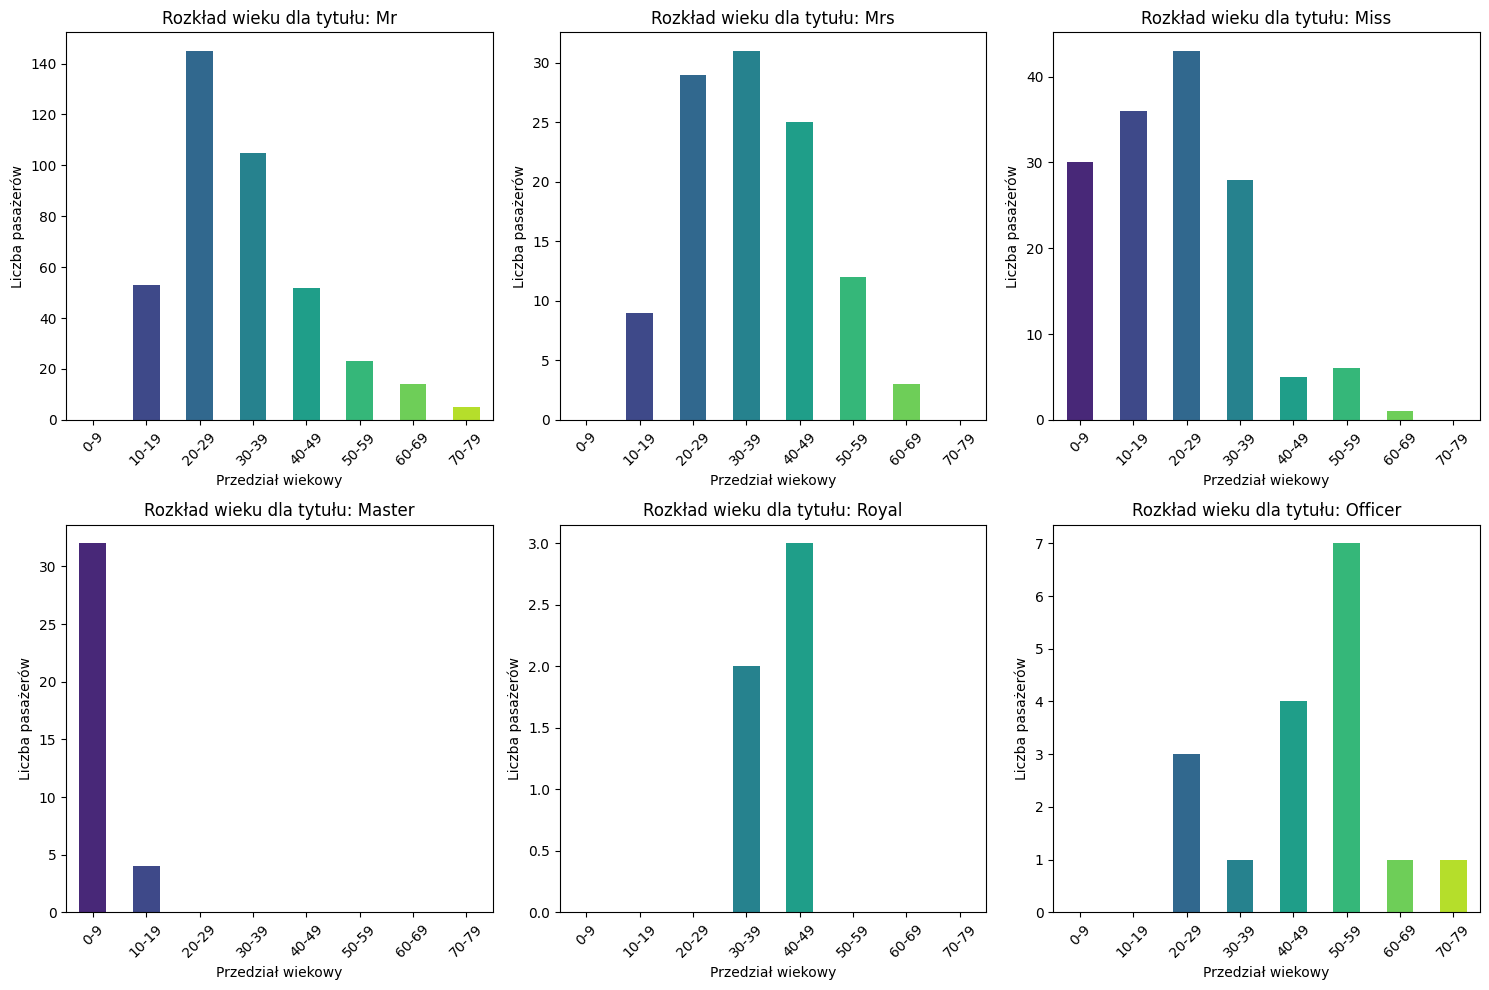

In [10]:
age_bins = [0, 10, 20, 30, 40, 50, 60, 70, 80]
age_labels = [f'{i}-{i+9}' for i in age_bins[:-1]]

titanic_df['AgeGroup'] = pd.cut(titanic_df['Age'], bins=age_bins, labels=age_labels, right=False)

unique_titles = titanic_df['Title'].unique()

n_titles = len(unique_titles)
n_cols = 3
n_rows = (n_titles + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
axes = axes.flatten()

for i, title in enumerate(unique_titles):
    title_data = titanic_df[titanic_df['Title'] == title]

    age_group_counts = title_data['AgeGroup'].value_counts().sort_index()

    age_group_counts.plot(kind='bar', ax=axes[i], color=sns.color_palette("viridis", len(age_group_counts)))

    axes[i].set_title(f'Rozkład wieku dla tytułu: {title}')
    axes[i].set_xlabel('Przedział wiekowy')
    axes[i].set_ylabel('Liczba pasażerów')
    axes[i].tick_params(axis='x', rotation=45)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [11]:
median_age_by_title = titanic_df.groupby('Title')['Age'].median()

def impute_age(row):
    if pd.isna(row['Age']):
        return median_age_by_title[row['Title']]
    return row['Age']

titanic_df['Age'] = titanic_df.apply(impute_age, axis=1)

print("Liczba braków danych w kolumnie 'Age' po uzupełnieniu:")
print(titanic_df['Age'].isna().sum())

Liczba braków danych w kolumnie 'Age' po uzupełnieniu:
0


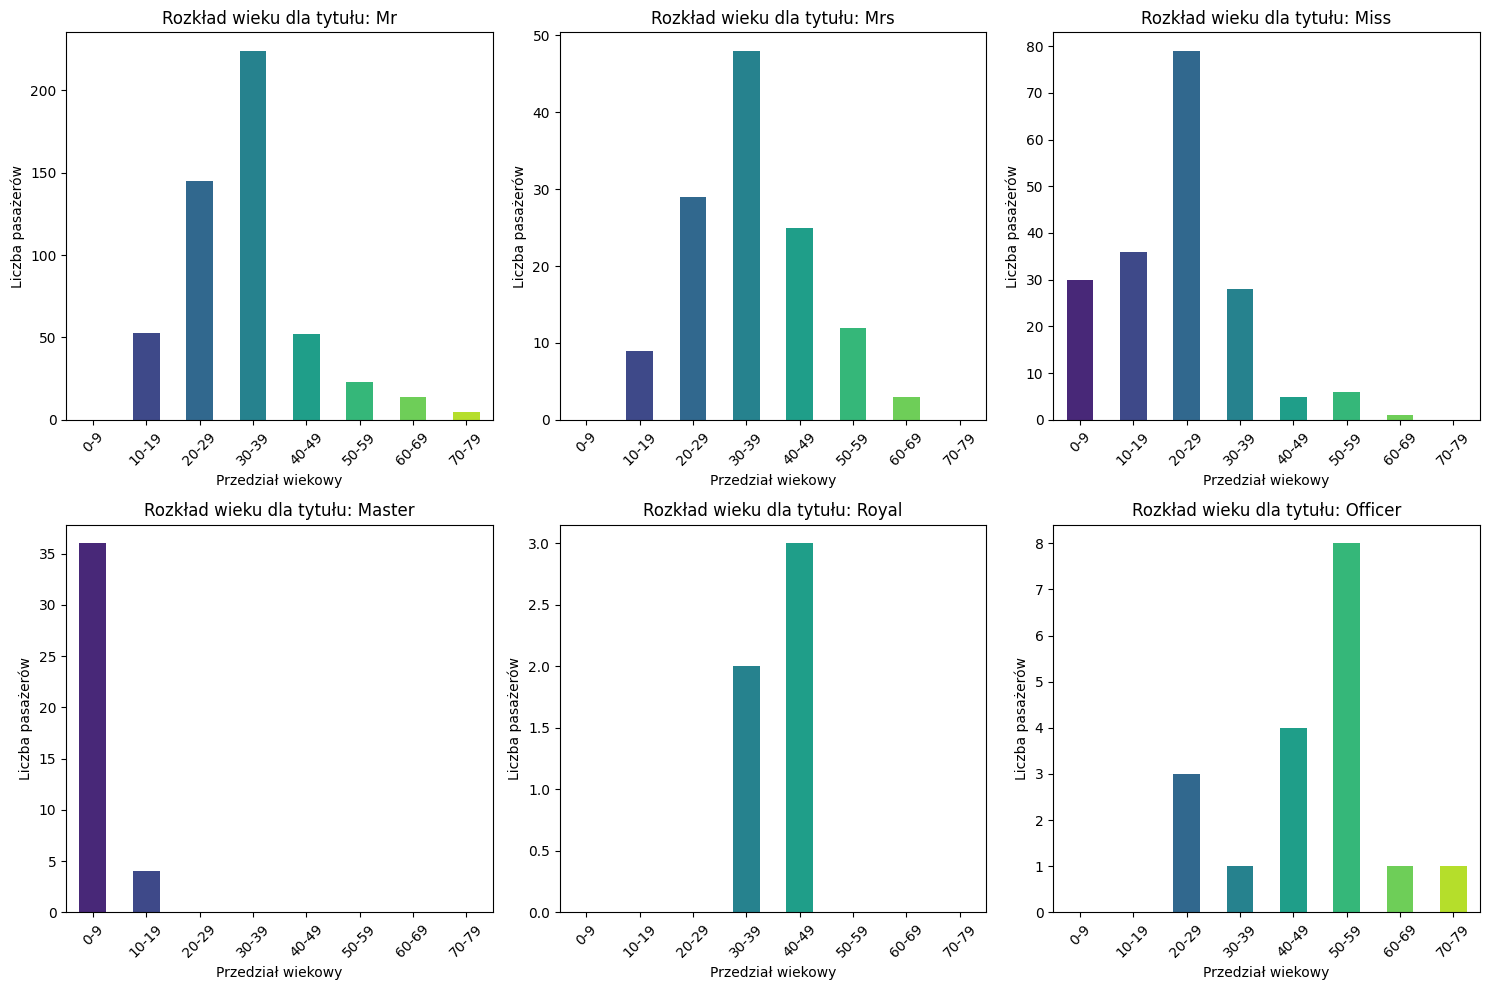

In [12]:
age_bins = [0, 10, 20, 30, 40, 50, 60, 70, 80]
age_labels = [f'{i}-{i+9}' for i in age_bins[:-1]]

titanic_df['AgeGroup'] = pd.cut(titanic_df['Age'], bins=age_bins, labels=age_labels, right=False)

unique_titles = titanic_df['Title'].unique()

n_titles = len(unique_titles)
n_cols = 3
n_rows = (n_titles + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
axes = axes.flatten()

for i, title in enumerate(unique_titles):
    title_data = titanic_df[titanic_df['Title'] == title]

    age_group_counts = title_data['AgeGroup'].value_counts().sort_index()

    age_group_counts.plot(kind='bar', ax=axes[i], color=sns.color_palette("viridis", len(age_group_counts)))

    axes[i].set_title(f'Rozkład wieku dla tytułu: {title}')
    axes[i].set_xlabel('Przedział wiekowy')
    axes[i].set_ylabel('Liczba pasażerów')
    axes[i].tick_params(axis='x', rotation=45)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

titanic_df.drop('AgeGroup', axis=1, inplace=True)

Dla danych wystepują teraz piki dla poszczególnych grup wiekowych, ale nie mam lepszego pomysłu jak je uzupełnić na ten moment.

In [13]:
print("Liczba braków danych w każdej kolumnie:")
print(titanic_df.isna().sum())

Liczba braków danych w każdej kolumnie:
Survived      0
Pclass        0
Name          0
Sex           0
Age           0
SibSp         0
Parch         0
Ticket        0
Fare         98
Cabin       687
Embarked      2
Title         0
dtype: int64


Zmienna Fare uzupełnie w podobny sposób co Age. tylko zamiast tytułu grupować będę klasą.

In [14]:
median_fare_by_pclass = titanic_df.groupby('Pclass')['Fare'].median()

def impute_fare(row):
    if pd.isna(row['Fare']):
        return median_fare_by_pclass[row['Pclass']]
    return row['Fare']

titanic_df['Fare'] = titanic_df.apply(impute_fare, axis=1)

print("Liczba braków danych w kolumnie 'Fare' po uzupełnieniu:")
print(titanic_df['Fare'].isna().sum())

Liczba braków danych w kolumnie 'Fare' po uzupełnieniu:
0


Kolumna Cabin zawiera za dużo braków więc ją po prostu usunę

In [15]:
titanic_df.drop('Cabin', axis=1, inplace=True)
print("Liczba braków danych w każdej kolumnie:")
print(titanic_df.isna().sum())

Liczba braków danych w każdej kolumnie:
Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Ticket      0
Fare        0
Embarked    2
Title       0
dtype: int64


Kolumne Embarked uzupełnie modą

In [16]:
mode_embarked = titanic_df['Embarked'].mode()[0]

titanic_df['Embarked'] = titanic_df['Embarked'].fillna(mode_embarked)

print("Liczba braków danych w kolumnie 'Embarked' po uzupełnieniu:")
print(titanic_df['Embarked'].isna().sum())

Liczba braków danych w kolumnie 'Embarked' po uzupełnieniu:
0


Dodatkowo utworzę kolumnę FamilySize która sumuje SibSp i Parch

In [17]:
titanic_df['FamilySize'] = titanic_df['SibSp'] + titanic_df['Parch'] + 1
print("Liczba braków danych w każdej kolumnie:")
print(titanic_df.isna().sum())

Liczba braków danych w każdej kolumnie:
Survived      0
Pclass        0
Name          0
Sex           0
Age           0
SibSp         0
Parch         0
Ticket        0
Fare          0
Embarked      0
Title         0
FamilySize    0
dtype: int64


Po uzupełnieniu danych muszę je przekształcić na wartości liczbowe dla modelu nie będzie miało znacznie ani kategoria Name ani Ticket więc moge je usunąć

In [18]:
titanic_df.drop('Name', axis=1, inplace=True)
titanic_df.drop('Ticket', axis=1, inplace=True)

In [19]:
categorical_cols = ['Sex', 'Embarked', 'Title', 'Pclass']

titanic_df_encoded = pd.get_dummies(titanic_df, columns=categorical_cols, drop_first=True)

print(titanic_df_encoded.head())

             Survived   Age  SibSp  Parch     Fare  FamilySize  Sex_male  \
PassengerId                                                                
1                   0  22.0      1      0   7.2500           2      True   
2                   1  38.0      1      0  71.2833           2     False   
3                   1  26.0      0      0   7.9250           1     False   
4                   1  35.0      1      0  53.1000           2     False   
5                   0  35.0      0      0   8.0500           1      True   

             Embarked_Q  Embarked_S  Title_Miss  Title_Mr  Title_Mrs  \
PassengerId                                                            
1                 False        True       False      True      False   
2                 False       False       False     False       True   
3                 False        True        True     False      False   
4                 False        True       False     False       True   
5                 False        True

Po przystosowaniu danych mogę przejść do trenowaniu modelu


Pierwszym krokiem będzi podział danych na testowe i treningowe.

In [20]:
from sklearn.model_selection import train_test_split

X = titanic_df_encoded.drop('Survived', axis=1)
y = titanic_df_encoded['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Kształt zbioru treningowego (X_train):", X_train.shape)
print("Kształt zbioru testowego (X_test):", X_test.shape)
print("Kształt zbioru treningowego (y_train):", y_train.shape)
print("Kształt zbioru testowego (y_test):", y_test.shape)

Kształt zbioru treningowego (X_train): (712, 15)
Kształt zbioru testowego (X_test): (179, 15)
Kształt zbioru treningowego (y_train): (712,)
Kształt zbioru testowego (y_test): (179,)


In [21]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)

y_train_pred_dummy = dummy_clf.predict(X_train)
y_test_pred_dummy = dummy_clf.predict(X_test)

print("Metryki dla Dummy Classifier (zbiór treningowy):")
print("Accuracy:", accuracy_score(y_train, y_train_pred_dummy))
print("Precision:", precision_score(y_train, y_train_pred_dummy, zero_division=0.0))
print("Recall:", recall_score(y_train, y_train_pred_dummy, zero_division=0.0))
print("F1-Score:", f1_score(y_train, y_train_pred_dummy, zero_division=0.0))

print("\nMetryki dla Dummy Classifier (zbiór testowy):")
print("Accuracy:", accuracy_score(y_test, y_test_pred_dummy))
print("Precision:", precision_score(y_test, y_test_pred_dummy, zero_division=0.0))
print("Recall:", recall_score(y_test, y_test_pred_dummy, zero_division=0.0))
print("F1-Score:", f1_score(y_test, y_test_pred_dummy, zero_division=0.0))

Metryki dla Dummy Classifier (zbiór treningowy):
Accuracy: 0.6235955056179775
Precision: 0.0
Recall: 0.0
F1-Score: 0.0

Metryki dla Dummy Classifier (zbiór testowy):
Accuracy: 0.5865921787709497
Precision: 0.0
Recall: 0.0
F1-Score: 0.0


In [22]:
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier(random_state=42)

dt_clf.fit(X_train, y_train)

y_train_pred_dt = dt_clf.predict(X_train)
y_test_pred_dt = dt_clf.predict(X_test)

print("Metryki dla drzewa decyzyjnego zbiór treningowy")
print("Accuracy:", accuracy_score(y_train, y_train_pred_dt))
print("Precision:", precision_score(y_train, y_train_pred_dt))
print("Recall:", recall_score(y_train, y_train_pred_dt))
print("F1-Score:", f1_score(y_train, y_train_pred_dt))

print("\nMetryki dla drzewa decyzyjnego zbiór testowy")
print("Accuracy:", accuracy_score(y_test, y_test_pred_dt))
print("Precision:", precision_score(y_test, y_test_pred_dt))
print("Recall:", recall_score(y_test, y_test_pred_dt))
print("F1-Score:", f1_score(y_test, y_test_pred_dt))

Metryki dla drzewa decyzyjnego zbiór treningowy
Accuracy: 0.976123595505618
Precision: 0.9921568627450981
Recall: 0.9440298507462687
F1-Score: 0.9674952198852772

Metryki dla drzewa decyzyjnego zbiór testowy
Accuracy: 0.7932960893854749
Precision: 0.7534246575342466
Recall: 0.7432432432432432
F1-Score: 0.7482993197278912


# Badanie hiperparametów
Teraz zbadamy wpływ wybranych hiperparametrów na model Drzewa Decyzyjnego. Skupimy się na max_depth i min_samples_split.


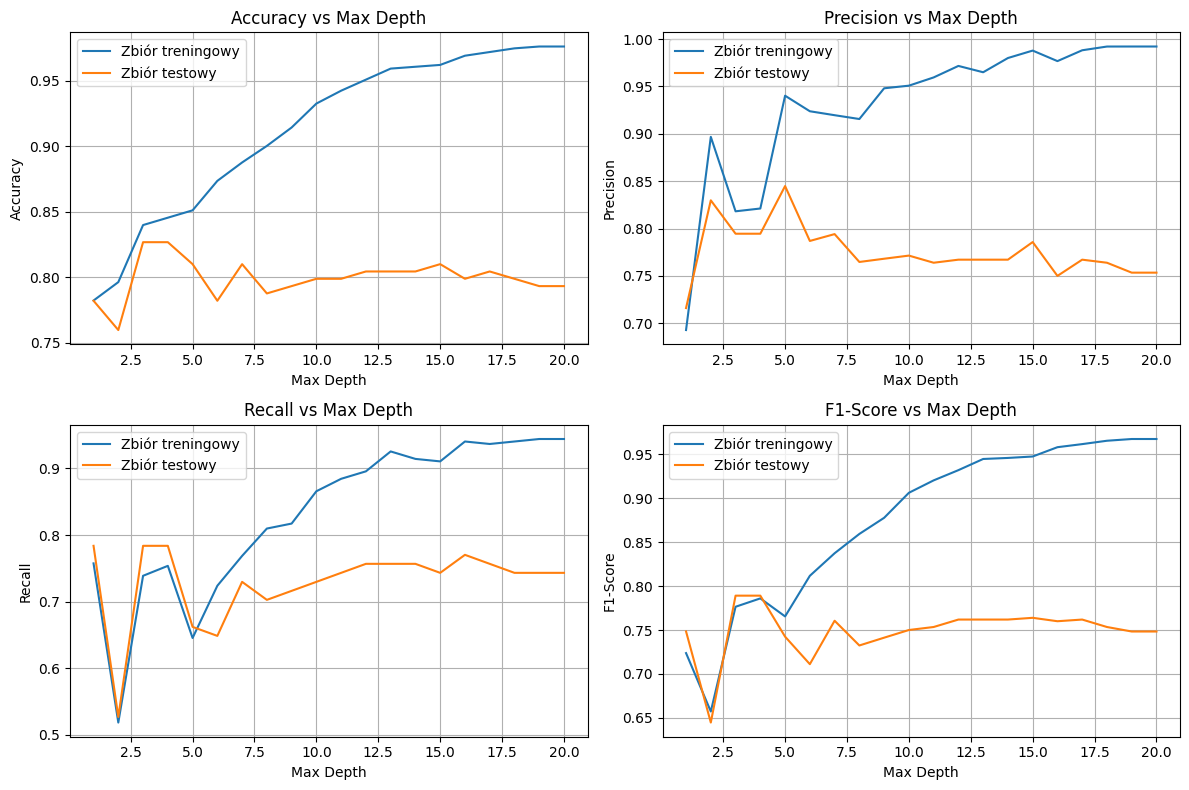

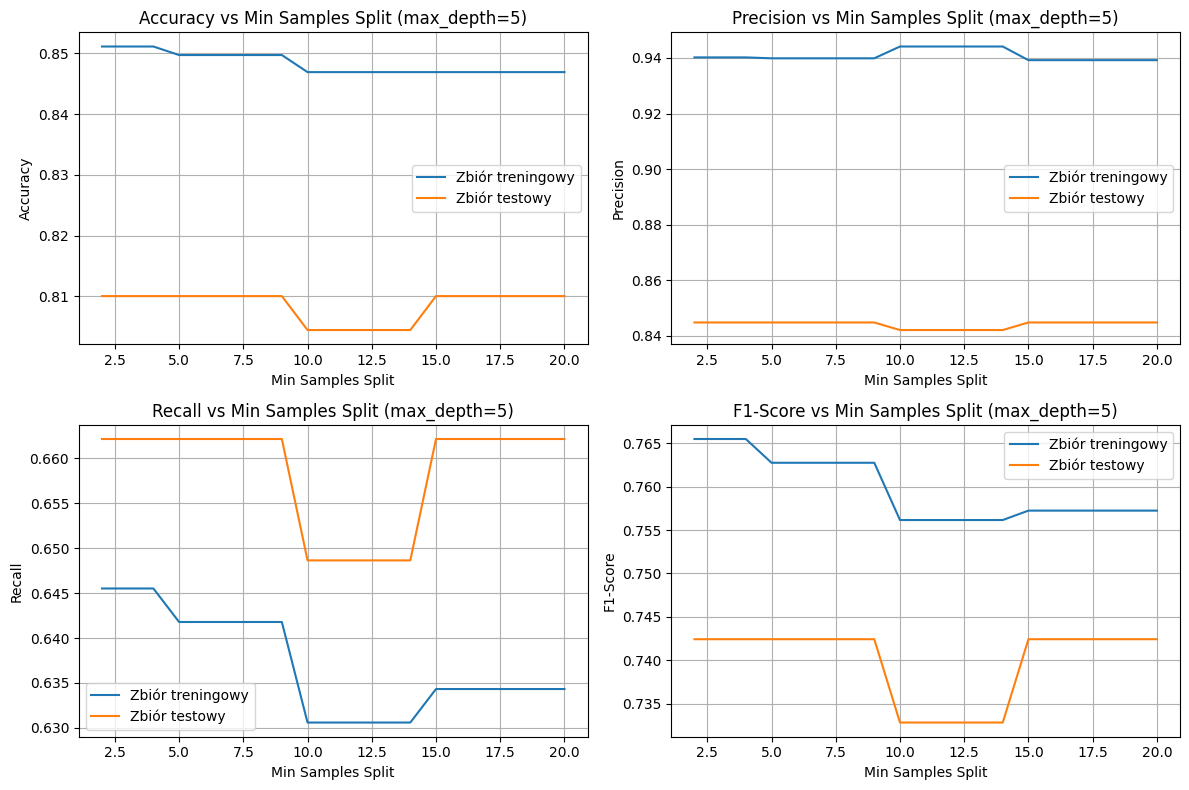

In [23]:
max_depth_values = range(1, 21)
min_samples_split_values = range(2, 21)

accuracy_train = []
accuracy_test = []
precision_train = []
precision_test = []
recall_train = []
recall_test = []
f1_train = []
f1_test = []

for depth in max_depth_values:
    dt_clf = DecisionTreeClassifier(max_depth=depth, random_state=42)
    dt_clf.fit(X_train, y_train)

    y_train_pred = dt_clf.predict(X_train)
    y_test_pred = dt_clf.predict(X_test)

    accuracy_train.append(accuracy_score(y_train, y_train_pred))
    accuracy_test.append(accuracy_score(y_test, y_test_pred))
    precision_train.append(precision_score(y_train, y_train_pred))
    precision_test.append(precision_score(y_test, y_test_pred))
    recall_train.append(recall_score(y_train, y_train_pred))
    recall_test.append(recall_score(y_test, y_test_pred))
    f1_train.append(f1_score(y_train, y_train_pred))
    f1_test.append(f1_score(y_test, y_test_pred))

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(max_depth_values, accuracy_train, label='Zbiór treningowy')
plt.plot(max_depth_values, accuracy_test, label='Zbiór testowy')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Max Depth')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(max_depth_values, precision_train, label='Zbiór treningowy')
plt.plot(max_depth_values, precision_test, label='Zbiór testowy')
plt.xlabel('Max Depth')
plt.ylabel('Precision')
plt.title('Precision vs Max Depth')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(max_depth_values, recall_train, label='Zbiór treningowy')
plt.plot(max_depth_values, recall_test, label='Zbiór testowy')
plt.xlabel('Max Depth')
plt.ylabel('Recall')
plt.title('Recall vs Max Depth')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(max_depth_values, f1_train, label='Zbiór treningowy')
plt.plot(max_depth_values, f1_test, label='Zbiór testowy')
plt.xlabel('Max Depth')
plt.ylabel('F1-Score')
plt.title('F1-Score vs Max Depth')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


accuracy_train_split = []
accuracy_test_split = []
precision_train_split = []
precision_test_split = []
recall_train_split = []
recall_test_split = []
f1_train_split = []
f1_test_split = []

for samples_split in min_samples_split_values:
    dt_clf = DecisionTreeClassifier(max_depth=5, min_samples_split=samples_split, random_state=42)
    dt_clf.fit(X_train, y_train)

    y_train_pred = dt_clf.predict(X_train)
    y_test_pred = dt_clf.predict(X_test)

    accuracy_train_split.append(accuracy_score(y_train, y_train_pred))
    accuracy_test_split.append(accuracy_score(y_test, y_test_pred))
    precision_train_split.append(precision_score(y_train, y_train_pred))
    precision_test_split.append(precision_score(y_test, y_test_pred))
    recall_train_split.append(recall_score(y_train, y_train_pred))
    recall_test_split.append(recall_score(y_test, y_test_pred))
    f1_train_split.append(f1_score(y_train, y_train_pred))
    f1_test_split.append(f1_score(y_test, y_test_pred))

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(min_samples_split_values, accuracy_train_split, label='Zbiór treningowy')
plt.plot(min_samples_split_values, accuracy_test_split, label='Zbiór testowy')
plt.xlabel('Min Samples Split')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Min Samples Split (max_depth=5)')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(min_samples_split_values, precision_train_split, label='Zbiór treningowy')
plt.plot(min_samples_split_values, precision_test_split, label='Zbiór testowy')
plt.xlabel('Min Samples Split')
plt.ylabel('Precision')
plt.title('Precision vs Min Samples Split (max_depth=5)')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(min_samples_split_values, recall_train_split, label='Zbiór treningowy')
plt.plot(min_samples_split_values, recall_test_split, label='Zbiór testowy')
plt.xlabel('Min Samples Split')
plt.ylabel('Recall')
plt.title('Recall vs Min Samples Split (max_depth=5)')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(min_samples_split_values, f1_train_split, label='Zbiór treningowy')
plt.plot(min_samples_split_values, f1_test_split, label='Zbiór testowy')
plt.xlabel('Min Samples Split')
plt.ylabel('F1-Score')
plt.title('F1-Score vs Min Samples Split (max_depth=5)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Max Depth


1.   **Zbiór treningowy**

* Dokładność ciągle rośnie wraz ze wzrostem głebokości. Jest to spowodowane uczeniem się na tych w kółko na tym samym zbiorze danych co prowadzi że model praktycznie zapamiętuje czy dany pasażer przeżyje, dlatego dla głębokości większych niż 12 model prawie się nie myli.
*  Wykresy dla Precision, Recall i F1-Score pokazują podobny trend. Wyniki na zbiorze treningowym rosną lub stabilizują się na bardzo wysokim poziomie.
2.   **Zbiór testowy**
* Dokładność na zbiorze testowym zachowuje się inaczej. Początkowo, gdy zwiększamy głębokość z 1 do około 4-6, dokładność na zbiorze testowym również rośnie. Drzewo o większej głębokości jest w stanie uchwycić bardziej złożone zależności w danych, co poprawia jego zdolność przewidywania na nowych danych. Jednak po osiągnięciu optymalnej głębokości, dokładność przestaje rosnąć lub nawet lekko spada, mimo że dokładność na zbiorze treningowym dalej rośnie.
* Reszta metryk zachowuje sie w podobny sposób (nie wiem z czego za to wynika spadek przy recall na głebokości ~2 🤷‍♂)
3. **Wnioski**
* Gdy max_depth jest małe, model jest zbyt prosty. Nie jest w stanie uchwycić wszystkich ważnych wzorców w danych, dlatego słabo radzi sobie zarówno na zbiorze treningowym, jak i testowym.
* Wraz ze wzrostem max_depth, model staje się bardziej złożony i lepiej uczy się wzorców. Wyniki poprawiają się na obu zbiorach.
* Gdy max_depth staje się zbyt duże, model staje się zbyt złożony. Zaczyna dopasowywać się nie tylko do rzeczywistych wzorców w danych treningowych, ale także do losowego szumu i specyficznych cech, które występują tylko w tym konkretnym zbiorze treningowym.

# Min Samples Split
1. Zbiór treningowy
* Patrząc na wykresy dla Accuracy, Precision, Recall i F1-Score, widzimy, że metryki na zbiorze treningowym są względnie stabilne w całym badanym zakresie wartości min_samples_split (od 2 do 20).
2. Zbiór testowy
* Metryki na zbiorze testowym również są względnie stabilne w całym badanym zakresie min_samples_split.
3. Wnioski
* W badanym zakresie wartości (od 2 do 20), hiperparametr min_samples_split ma ograniczony wpływ na wydajność modelu Drzewa Decyzyjnego, gdy max_depth jest ustawione na 5.
* Wydaje się, że w tym konkretnym przypadku i przy tej ustalonej głębokości, zmiana minimalnej liczby próbek wymaganej do podziału węzła nie powoduje znaczącego przetrenowania ani niedouczenia

# Model MLP

### Standaryzacja danych dla modelu MLP
Przeskalujem dane, aby miały średnią 0 i odchylenie standardowe 1.


In [24]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)

print("Kształt przeskalowanego zbioru treningowego:", X_train_scaled.shape)
print("Kształt przeskalowanego zbioru testowego:", X_test_scaled.shape)

print("\nŚrednia przeskalowanego zbioru treningowego:", X_train_scaled.mean(axis=0)[:5])
print("Odchylenie standardowe przeskalowanego zbioru treningowego:", X_train_scaled.std(axis=0)[:5])

Kształt przeskalowanego zbioru treningowego: (712, 15)
Kształt przeskalowanego zbioru testowego: (179, 15)

Średnia przeskalowanego zbioru treningowego: [ 9.23106785e-17  1.74641824e-17  2.24539488e-17 -5.86297552e-17
 -4.98976640e-17]
Odchylenie standardowe przeskalowanego zbioru treningowego: [1. 1. 1. 1. 1.]


Teraz możemy wytrenować model MLP



In [25]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


mlp_clf_scaled = MLPClassifier(random_state=42, max_iter=1000)

mlp_clf_scaled.fit(X_train_scaled, y_train)

y_train_pred_mlp_scaled = mlp_clf_scaled.predict(X_train_scaled)
y_test_pred_mlp_scaled = mlp_clf_scaled.predict(X_test_scaled)

print("Metryki dla MLP Classifier zbiór treningowy - przeskalowany")
print("Accuracy:", accuracy_score(y_train, y_train_pred_mlp_scaled))
print("Precision:", precision_score(y_train, y_train_pred_mlp_scaled))
print("Recall:", recall_score(y_train, y_train_pred_mlp_scaled))
print("F1-Score:", f1_score(y_train, y_train_pred_mlp_scaled))

print("\nMetryki dla MLP Classifier zbiór testowy - przeskalowany")
print("Accuracy:", accuracy_score(y_test, y_test_pred_mlp_scaled))
print("Precision:", precision_score(y_test, y_test_pred_mlp_scaled))
print("Recall:", recall_score(y_test, y_test_pred_mlp_scaled))
print("F1-Score:", f1_score(y_test, y_test_pred_mlp_scaled))

Metryki dla MLP Classifier zbiór treningowy - przeskalowany
Accuracy: 0.8778089887640449
Precision: 0.91324200913242
Recall: 0.746268656716418
F1-Score: 0.8213552361396304

Metryki dla MLP Classifier zbiór testowy - przeskalowany
Accuracy: 0.7988826815642458
Precision: 0.7714285714285715
Recall: 0.7297297297297297
F1-Score: 0.75


# Badanie hiperparametrów


# Badanie hiperparametrów modelu MLP
Zbadamy wpływ max_iter i learning_rate_init na wydajność modelu MLP na przeskalowanych danych.
* max_iter: określa, ile razy cały zbiór treningowy zostanie przejrzany przez algorytm optymalizacyjny w celu aktualizacji wag sieci.
* learing_rate_init: określa jak duży krok wykonuje algorytm optymalizacyjny przy każdej aktualizacji wag sieci podczas treningu. Jest to początkowa wartość tempa uczenia.

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (750) reached and the optimization hasn't converged yet.
  warnings.warn(


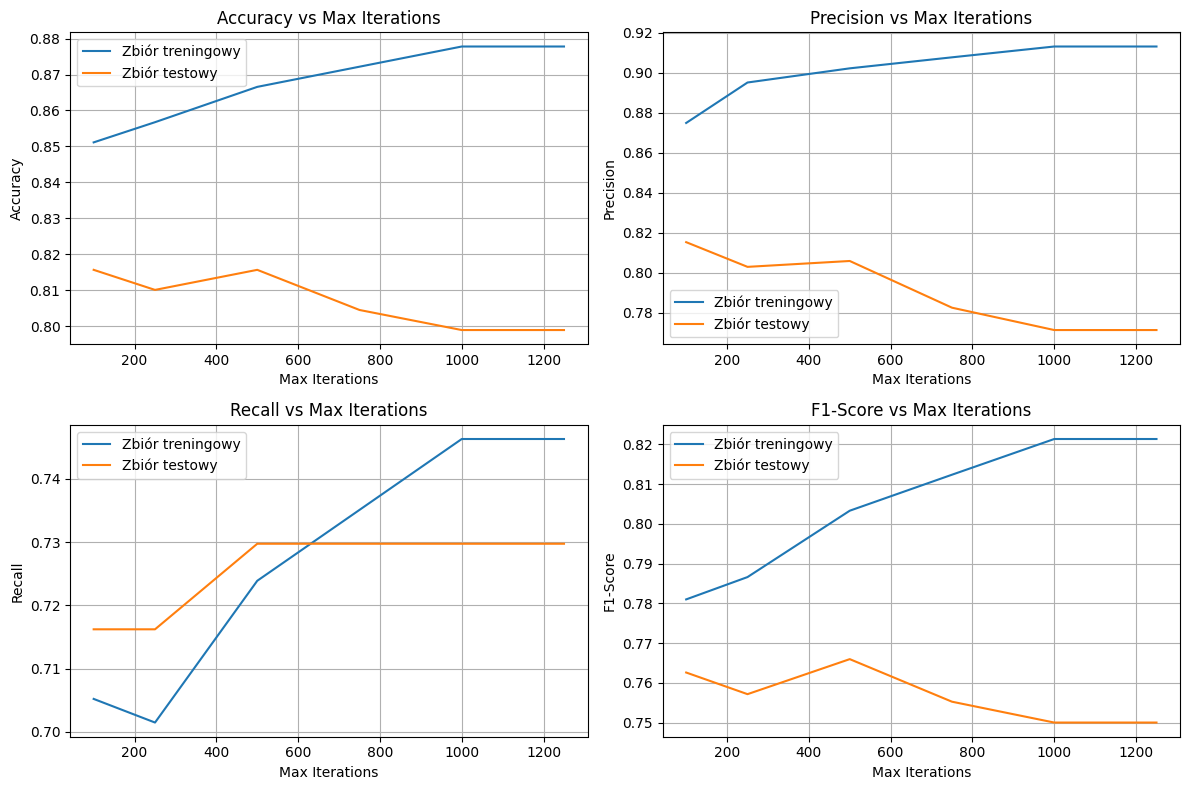

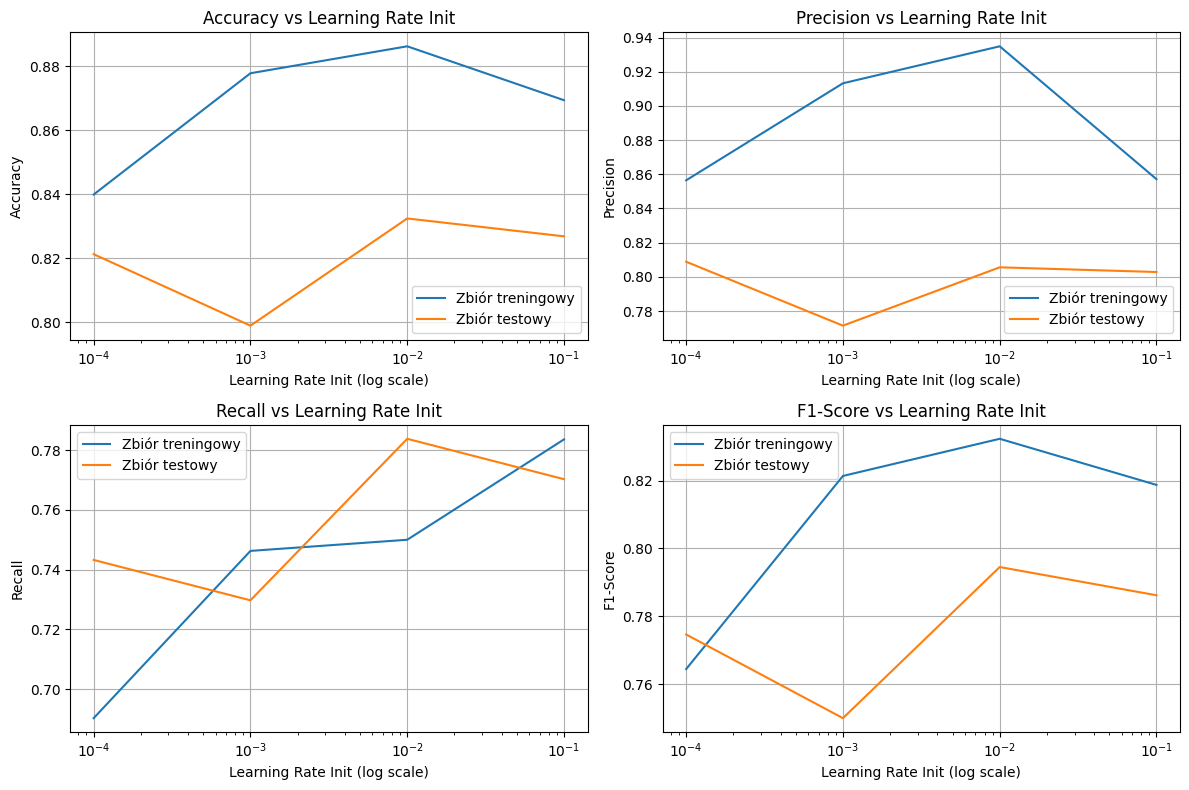

In [28]:
max_iter_values = [100, 250, 500, 750, 1000, 1250]
learning_rate_init_values = [0.0001, 0.001, 0.01, 0.1]

fixed_learning_rate = 0.001
fixed_max_iter = 1000

accuracy_train_iter = []
accuracy_test_iter = []
precision_train_iter = []
precision_test_iter = []
recall_train_iter = []
recall_test_iter = []
f1_train_iter = []
f1_test_iter = []

for iter_count in max_iter_values:
    mlp_clf = MLPClassifier(random_state=42, max_iter=iter_count, learning_rate_init=fixed_learning_rate)
    mlp_clf.fit(X_train_scaled, y_train)

    y_train_pred = mlp_clf.predict(X_train_scaled)
    y_test_pred = mlp_clf.predict(X_test_scaled)

    accuracy_train_iter.append(accuracy_score(y_train, y_train_pred))
    accuracy_test_iter.append(accuracy_score(y_test, y_test_pred))
    precision_train_iter.append(precision_score(y_train, y_train_pred))
    precision_test_iter.append(precision_score(y_test, y_test_pred))
    recall_train_iter.append(recall_score(y_train, y_train_pred))
    recall_test_iter.append(recall_score(y_test, y_test_pred))
    f1_train_iter.append(f1_score(y_train, y_train_pred))
    f1_test_iter.append(f1_score(y_test, y_test_pred))

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(max_iter_values, accuracy_train_iter, label='Zbiór treningowy')
plt.plot(max_iter_values, accuracy_test_iter, label='Zbiór testowy')
plt.xlabel('Max Iterations')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Max Iterations')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(max_iter_values, precision_train_iter, label='Zbiór treningowy')
plt.plot(max_iter_values, precision_test_iter, label='Zbiór testowy')
plt.xlabel('Max Iterations')
plt.ylabel('Precision')
plt.title('Precision vs Max Iterations')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(max_iter_values, recall_train_iter, label='Zbiór treningowy')
plt.plot(max_iter_values, recall_test_iter, label='Zbiór testowy')
plt.xlabel('Max Iterations')
plt.ylabel('Recall')
plt.title('Recall vs Max Iterations')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(max_iter_values, f1_train_iter, label='Zbiór treningowy')
plt.plot(max_iter_values, f1_test_iter, label='Zbiór testowy')
plt.xlabel('Max Iterations')
plt.ylabel('F1-Score')
plt.title('F1-Score vs Max Iterations')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


accuracy_train_lr = []
accuracy_test_lr = []
precision_train_lr = []
precision_test_lr = []
recall_train_lr = []
recall_test_lr = []
f1_train_lr = []
f1_test_lr = []

for lr in learning_rate_init_values:
    mlp_clf = MLPClassifier(random_state=42, max_iter=fixed_max_iter, learning_rate_init=lr)
    mlp_clf.fit(X_train_scaled, y_train)

    y_train_pred = mlp_clf.predict(X_train_scaled)
    y_test_pred = mlp_clf.predict(X_test_scaled)

    accuracy_train_lr.append(accuracy_score(y_train, y_train_pred))
    accuracy_test_lr.append(accuracy_score(y_test, y_test_pred))
    precision_train_lr.append(precision_score(y_train, y_train_pred))
    precision_test_lr.append(precision_score(y_test, y_test_pred))
    recall_train_lr.append(recall_score(y_train, y_train_pred))
    recall_test_lr.append(recall_score(y_test, y_test_pred))
    f1_train_lr.append(f1_score(y_train, y_train_pred))
    f1_test_lr.append(f1_score(y_test, y_test_pred))

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(learning_rate_init_values, accuracy_train_lr, label='Zbiór treningowy')
plt.plot(learning_rate_init_values, accuracy_test_lr, label='Zbiór testowy')
plt.xscale('log')
plt.xlabel('Learning Rate Init (log scale)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Learning Rate Init')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(learning_rate_init_values, precision_train_lr, label='Zbiór treningowy')
plt.plot(learning_rate_init_values, precision_test_lr, label='Zbiór testowy')
plt.xscale('log')
plt.xlabel('Learning Rate Init (log scale)')
plt.ylabel('Precision')
plt.title('Precision vs Learning Rate Init')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(learning_rate_init_values, recall_train_lr, label='Zbiór treningowy')
plt.plot(learning_rate_init_values, recall_test_lr, label='Zbiór testowy')
plt.xscale('log')
plt.xlabel('Learning Rate Init (log scale)')
plt.ylabel('Recall')
plt.title('Recall vs Learning Rate Init')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(learning_rate_init_values, f1_train_lr, label='Zbiór treningowy')
plt.plot(learning_rate_init_values, f1_test_lr, label='Zbiór testowy')
plt.xscale('log')
plt.xlabel('Learning Rate Init (log scale)')
plt.ylabel('F1-Score')
plt.title('F1-Score vs Learning Rate Init')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# max_iter

1.   Zbiór treningowy
* Patrząc na wykresy Accuracy, Precision, Recall i F1-Score w funkcji max_iter dla zbioru treningowego, metryki szybko rosną dla małej ilości iteracji i stabilizują się po "ukończeniu" nauki przy 1000 iteracji, ani nie rosną ani nie maleją
2.   Zbiór testowy
 * Metryki na zbiorze testowym również rosną lub są stabilne od 100 do około 500 iteracji, natomiast po przekroczeniu ~500 iteracji metryki maleją o około jeden procent(lub nawet 4 w przypadku precision) co może sugerować przećwiczenie modelu.
 3. Wnioski
 * Zaskakująco(dla mnie) model osiąga lepsze wyniki, kiedy nie jest w pełnie wytrenowany

# learing_rate_init
1.   Zbiór treningowy
* Patrząc na wykresy (Accuracy, Precision, Recall, F1) dla zbioru treningowego, metryki rosną znacząco od najmniejszej wartości 0.0001 do wartości 0.001 i 0.01. Dla wartości 0.1 metryki spadają.
* Zbyt niskie tempo uczenia 0.0001 powoduje, że model uczy się wolno i nie osiąga wysokiej wydajności na zbiorze treningowym w ciągu 1000 iteracji. Wartości 0.001 i 0.01 pozwalają modelowi skutecznie minimalizować błąd na danych treningowych. Bardzo wysokie tempo uczenia 0.1 zakłóca proces optymalizacji i pogarsza dopasowanie nawet do danych treningowych.
2.   Zbiór testowy
*  Metryki na zbiorze testowym maleją od 0.0001 do 0.001. Potem znów rosną, aby osiągnąć swoje maksimum w punkcie 0.01, by potem ponownie się zmniejszyć.
* Zbyt niskie tempo uczenia 0.0001 skutkuje słabą generalizacją, ponieważ model nie zdążył się dobrze nauczyć.  0.01 wydaje się być optymalne dla generalizacji na nowe dane – model uczy się wystarczająco szybko i stabilnie. Bardzo wysokie tempo uczenia 0.1 prowadzi do niestabilności procesu uczenia, co skutkuje pogorszeniem wyników na zbiorze testowym
3. Wnioski
* Parametr learning_rate_init ma krytyczny wpływ na proces uczenia MLP i jego końcową wydajność, zarówno na zbiorze treningowym, jak i testowym.
* Zbyt niskie tempo uczenia 0.0001 prowadzi do niedouczenia
* Zbyt wysokie tempo uczenia 0.1 prowadzi do niestabilności procesu uczenia i pogorszenia generalizacj


# Podsumowanie
Po wytrenowaniu modeli do przewidywania przeżycia pasażerów Titanica, model bazowy Dummy Classifier uzyskał bardzo słabe wyniki, co było spodziewane. Modele bardziej zawaansowane poradziły sobie znacznie lepiej z tym zadaniem osiągając wyższe metryki na zbiorze testowym. Oba modele wykazały porównywalną wydajność